In [2]:
!pip install py2neo 

In [33]:
from py2neo import Graph
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%3f' % x)

import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [34]:
graph = Graph("bolt://localhost", auth=("neo4j", "neo"))

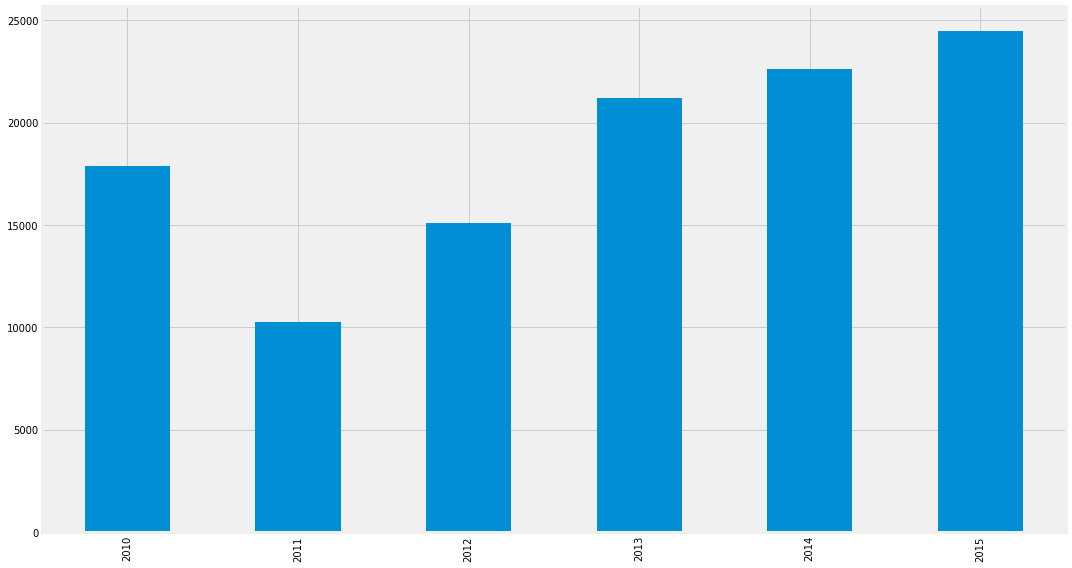

In [5]:
query = """
MATCH (cr:Crashes) 
WITH cr.Year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

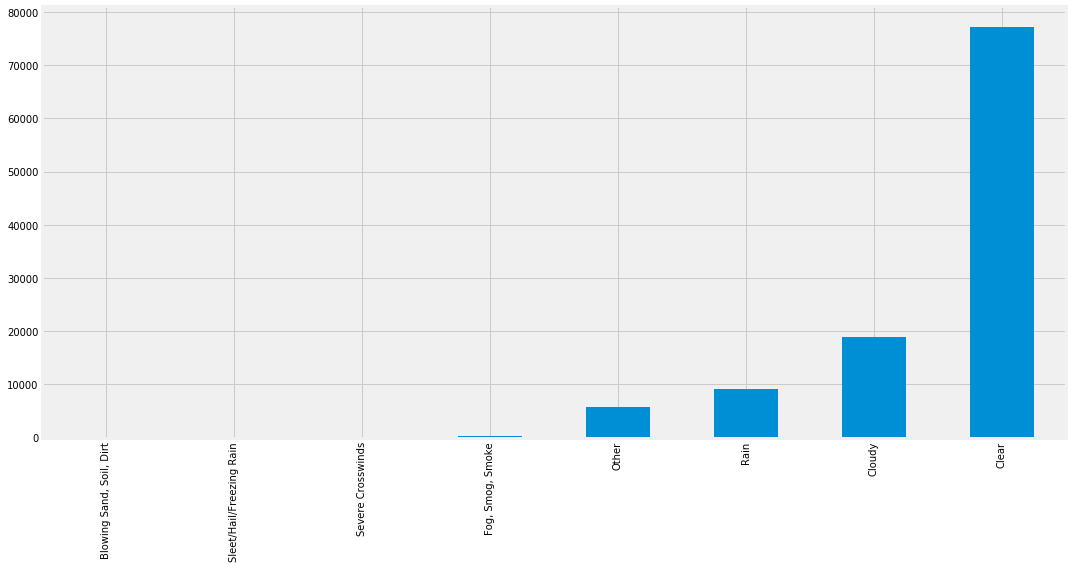

In [6]:
query = """
MATCH (cr:Crashes)-[r]-(inf:InF_Factor)
WITH inf.Weather AS wh, count(*) AS count
ORDER BY count
RETURN wh AS wh, count
"""
by_cond = graph.run(query).to_data_frame()

ax = by_cond.plot(kind='bar', x='wh', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [10]:
query = """
MATCH (int1)<-[:LOCATED_AT]-(cr: Crashes)-[:LOCATED_AT]->(int2:Streets)
WITH int1, cr, int2
ORDER BY int1, cr.Year
WITH int1, int2, collect(cr)[0].Year AS year, count(*) AS colocation
MERGE (int1)-[Co:Colocation {Year: year}]-(int2)
SET Co.colocation = colocation;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 9140
relationships_created: 4570
relationships_deleted: 0

In [11]:
query = """
MATCH (int1)<-[:LOCATED_AT]-(cr: Crashes)-[:LOCATED_AT]->(int2:Streets)
WITH int1, cr, int2
ORDER BY int1, cr.Year
WITH int1, int2, collect(cr)[0].Year AS year, count(*) AS colocation
WHERE year < 2014
MERGE (int1)-[Co:Colocation_Early {Year: year}]-(int2)
SET Co.colocation = colocation;
"""

graph.run(query).stats()


constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 6896
relationships_created: 3448
relationships_deleted: 0

In [12]:
query = """
MATCH (int1)<-[:LOCATED_AT]-(cr: Crashes)-[:LOCATED_AT]->(int2:Streets)
WITH int1, cr, int2
ORDER BY int1, cr.Year
WITH int1, int2, collect(cr)[0].Year AS year, count(*) AS colocation
WHERE year >= 2014
MERGE (int1)-[Co:Colocation_Late {Year: year}]-(int2)
SET Co.colocation = colocation;
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contained_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 2244
relationships_created: 1122
relationships_deleted: 0

In [13]:
query = """
MATCH ()-[:Colocation_Late]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,1122


In [14]:
query = """
MATCH ()-[:Colocation_Early]->()
RETURN count(*) AS count
"""

graph.run(query).to_data_frame()

,count
0,3448


In [15]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [24]:
train_existing_links = graph.run("""
MATCH (int:Intersections)-[:Colocation_Early]->(other:Streets)
RETURN id(int) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (int:Intersections)
WHERE (int)-[:Colocation_Early]-()
MATCH (int)-[:Colocation_Early*2..3]-(other)
WHERE not((int)-[:Colocation_Early]-(other))
RETURN id(int) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()


In [26]:
train_missing_links.head()

,label,node1,node2
0,0,8586,9869
1,0,8586,32029
2,0,8586,22080
3,0,8586,11432
4,0,8586,34113


In [27]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [28]:
training_df.head()

,label,node1,node2
128173,1,22030,1675
129851,1,16828,3783
127626,1,26399,448
127582,1,11359,446
120605,0,30965,34130


In [29]:
test_existing_links = graph.run("""
MATCH (int:Intersections)-[:Colocation_Late]->(other:Streets)
RETURN id(int) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (int:Intersections)
WHERE (int)-[:Colocation_Late]-()
MATCH (int)-[:Colocation_Late*2..3]-(other)
WHERE not((int)-[:Colocation_Late]-(other))
RETURN id(int) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [30]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [31]:
test_df.head()

,label,node1,node2
25518,1,11705,2348
21738,0,23572,10282
269,0,9764,11326
42,0,9756,11097
19520,0,23492,11412


In [32]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

In [35]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [36]:
training_df = apply_graphy_features(training_df, "Colocation_Early")

In [37]:
training_df.head()

,label,node1,node2,cn,pa,tn
0,1,22030,1675,0.000000,8.000000,9.000000
1,1,16828,3783,0.000000,1.000000,2.000000
2,1,26399,448,0.000000,20.000000,21.000000
3,1,11359,446,0.000000,522.000000,93.000000
4,0,30965,34130,1.000000,1.000000,1.000000


In [38]:

test_df = apply_graphy_features(test_df, "Colocation_Late")

In [39]:
test_df.head()

,label,node1,node2,cn,pa,tn
0,1,11705,2348,0.000000,178.000000,91.000000
1,0,23572,10282,1.000000,1.000000,1.000000
2,0,9764,11326,2.000000,4.000000,2.000000
3,0,9756,11097,2.000000,4.000000,2.000000
4,0,23492,11412,1.000000,1.000000,1.000000


In [40]:
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

1.0

'Precision'

1.0

'Recall'

1.0

[('cn', 1.0)]

In [41]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display("Accuracy", accuracy_score(y_test, predictions))
display("Precision", precision_score(y_test, predictions))
display("Recall", recall_score(y_test, predictions))

sorted(list(zip(columns, classifier.feature_importances_)), key = lambda x: x[1]*-1)

'Accuracy'

0.9982174688057041

'Precision'

1.0

'Recall'

0.9964349376114082

[('cn', 0.5860222232533139),
 ('tn', 0.24811845952115621),
 ('pa', 0.16585931722553)]

In [42]:
graph.run("""
CALL algo.triangleCount('Intersections', 'Colocation_Early', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.000000,coefficientTrain,54,168,25905,0,0,0,0,0,0,0,0,0,0,830,0,True,19,trianglesTrain


In [43]:
graph.run("""
CALL algo.triangleCount('Intersections', 'Colocation_Late', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,averageClusteringCoefficient,clusteringCoefficientProperty,computeMillis,loadMillis,nodeCount,p1,p10,p100,p25,p5,p50,p75,p90,p95,p99,postProcessingMillis,triangleCount,write,writeMillis,writeProperty
0,0.000000,coefficientTrain,76,59,25905,0,0,0,0,0,0,0,0,0,0,143,0,True,3,trianglesTrain


In [46]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [49]:
graph.run("""
CALL algo.labelPropagation("Intersections", "Colocation_Early", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,25905,28,True,1,35,25905,1,1,1,1,...,1,1,1,1,partitionTrain,322,weight,True,44,partitionTrain


In [50]:
graph.run("""
CALL algo.labelPropagation("Intersections", "Colocation_Late", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,communityCount,computeMillis,didConverge,iterations,loadMillis,nodes,p1,p10,p100,p25,...,p75,p90,p95,p99,partitionProperty,postProcessingMillis,weightProperty,write,writeMillis,writeProperty
0,25905,47,True,1,74,25905,1,1,1,1,...,1,1,1,1,partitionTrain,51,weight,True,20,partitionTrain


In [51]:
graph.run("""
CALL algo.louvain.stream("Intersections", "Colocation_Early", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contained_updates: False
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 0
relationships_created: 0
relationships_deleted: 0